In [2]:
import os
import sys

# Get the current notebook's directory
notebook_dir = os.path.dirname(os.path.abspath('__file__'))

# Get the project root directory (two levels up from the notebook)
project_root = os.path.abspath(os.path.join(notebook_dir, '..'))

# Add the project root to the Python path
if project_root not in sys.path:
    sys.path.append(project_root)

In [3]:
import warnings

warnings.filterwarnings('ignore')

In [4]:
import os
import pandas as pd
import numpy as np
from pmdarima import auto_arima
import pickle
import machine_learning
from sklearn.metrics import mean_squared_error

In [5]:
# Construct the full path to the data file using project_root
data_path = os.path.join(project_root, 'data', 'dallas_stations_data.csv')

# Read the CSV file
dallas_data = pd.read_csv(data_path)

dallas_data

,DATE,value,element,STATION_ID
0,2005-01-01,0.0,PRCP,US1TXDA0001
1,2005-01-02,23.1,PRCP,US1TXDA0001
2,2005-01-03,42.7,PRCP,US1TXDA0001
3,2005-01-04,5.3,PRCP,US1TXDA0001
4,2005-01-05,4.8,PRCP,US1TXDA0001
...,...,...,...,...
1477572,1940-08-27,0.0,SNWD,USW00093928
1477573,1940-08-28,0.0,SNWD,USW00093928
1477574,1940-08-29,0.0,SNWD,USW00093928
1477575,1940-08-30,0.0,SNWD,USW00093928


In [6]:
# Filter the DataFrame to keep only the desired elements
filtered_data = dallas_data[dallas_data['element'].isin(['TMAX', 'TMIN', 'PRCP', 'SNOW', 'SNWD'])]

# Display first few rows of the filtered data
filtered_data.head(10)


,DATE,value,element,STATION_ID
0,2005-01-01,0.0,PRCP,US1TXDA0001
1,2005-01-02,23.1,PRCP,US1TXDA0001
2,2005-01-03,42.7,PRCP,US1TXDA0001
3,2005-01-04,5.3,PRCP,US1TXDA0001
4,2005-01-05,4.8,PRCP,US1TXDA0001
5,2005-01-06,0.0,PRCP,US1TXDA0001
6,2005-01-07,0.0,PRCP,US1TXDA0001
7,2005-01-08,0.0,PRCP,US1TXDA0001
8,2005-01-09,0.0,PRCP,US1TXDA0001
9,2005-01-10,0.0,PRCP,US1TXDA0001


In [7]:
# Group by DATE and element, calculate mean value, and reset index
averaged_data = filtered_data.groupby(['DATE', 'element'])['value'].mean().reset_index()

# Sort the data by DATE for better organization
averaged_data = averaged_data.sort_values('DATE')

# Display the first few rows to verify the results
averaged_data

,DATE,element,value
0,1893-01-01,PRCP,0.000000
1,1893-01-01,SNOW,0.000000
2,1893-01-01,TMAX,13.300000
3,1893-01-01,TMIN,-1.100000
4,1893-01-02,PRCP,0.000000
...,...,...,...
237697,2025-04-27,SNOW,0.000000
237698,2025-04-27,SNWD,0.000000
237700,2025-04-27,TMIN,19.633333
237701,2025-04-28,PRCP,0.000000


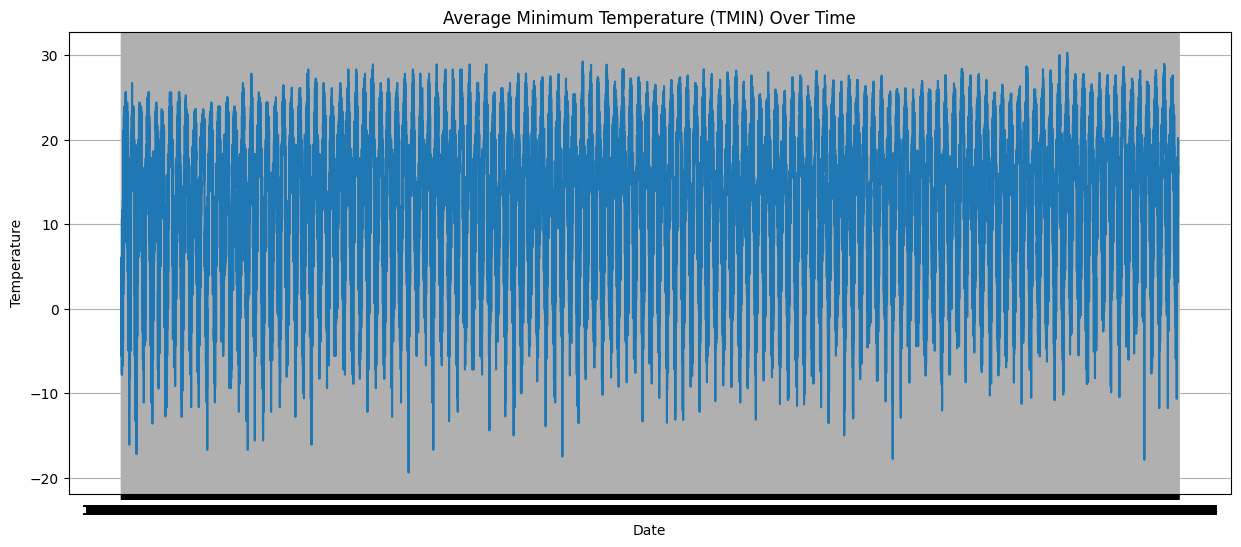

In [8]:
import matplotlib.pyplot as plt

# Filter for TMIN data
tmin_data = averaged_data[averaged_data['element'] == 'TMIN']

# Create the plot
plt.figure(figsize=(15, 6))
plt.plot(tmin_data['DATE'], tmin_data['value'])
plt.title('Average Minimum Temperature (TMIN) Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.grid(True)
plt.show()

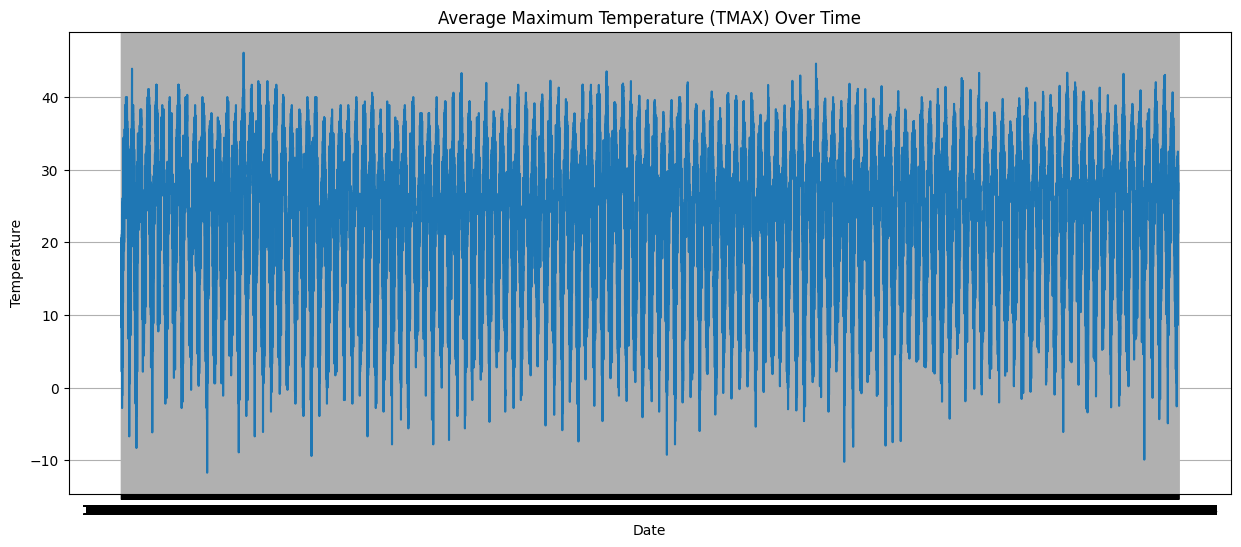

In [9]:
# Filter for TMAX data
tmax_data = averaged_data[averaged_data['element'] == 'TMAX']

# Create the plot
plt.figure(figsize=(15, 6))
plt.plot(tmax_data['DATE'], tmax_data['value'])
plt.title('Average Maximum Temperature (TMAX) Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.grid(True)
plt.show()

In [10]:
# Filter for SNOW data
snow_data = averaged_data[averaged_data['element'] == 'SNOW']

# Create the plot
plt.figure(figsize=(15, 6))
plt.plot(snow_data['DATE'], snow_data['value'])
plt.title('Average Snowfall (SNOW) Over Time')
plt.xlabel('Date')
plt.ylabel('Snowfall')
plt.grid(True)
plt.show()

KeyboardInterrupt: 

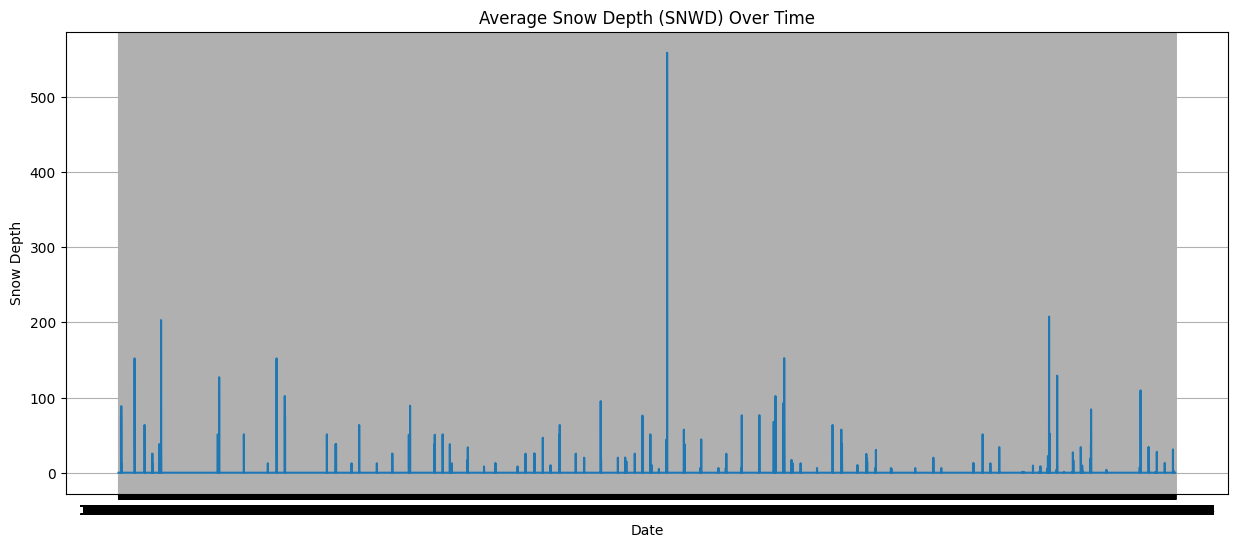

In [ ]:
# Filter for SNWD data
snwd_data = averaged_data[averaged_data['element'] == 'SNWD']

# Create the plot
plt.figure(figsize=(15, 6))
plt.plot(snwd_data['DATE'], snwd_data['value'])
plt.title('Average Snow Depth (SNWD) Over Time')
plt.xlabel('Date')
plt.ylabel('Snow Depth')
plt.grid(True)
plt.show()

In [ ]:
averaged_data

,DATE,element,value
0,1893-01-01,PRCP,0.000000
1,1893-01-01,SNOW,0.000000
2,1893-01-01,TMAX,13.300000
3,1893-01-01,TMIN,-1.100000
4,1893-01-02,PRCP,0.000000
...,...,...,...
237697,2025-04-27,SNOW,0.000000
237698,2025-04-27,SNWD,0.000000
237700,2025-04-27,TMIN,19.633333
237701,2025-04-28,PRCP,0.000000


In [ ]:
def smape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.abs(y_true - y_pred)
    
    # Avoid division by zero
    nonzero = denominator != 0
    smape = np.mean(diff[nonzero] / denominator[nonzero]) * 100
    
    return smape

In [ ]:
def clean_data(data):
    """
    Clean and prepare time series data for analysis.
    
    Parameters:
    -----------
    data : pandas.DataFrame
        Raw data with 'year', 'month', 'day', and 'value' columns
        
    Returns:
    --------
    pandas.DataFrame
        Cleaned data with datetime index and resampled values
    """
    try:
        # Create a copy to avoid modifying the original data
        data = data.copy()
        
        # Create DATE column from year, month, and day
        data["DATE"] = pd.to_datetime(data[["year", "month", "day"]], errors="coerce")
        
        # Drop rows with invalid dates
        data = data.dropna(subset=["DATE"])
        
        # Drop rows with missing values
        data = data.dropna(subset=["value"])
        
        # Convert value column to float
        data['value'] = pd.to_numeric(data['value'], errors='coerce')
        data = data.dropna(subset=["value"])
        
        # Set DATE as index and keep only the value column
        data = data.set_index("DATE")[["value"]]
        
        # Resample to monthly frequency and handle missing values
        data = data.resample("ME").mean()  # Using ME instead of M for month end
        
        # Forward fill any remaining missing values
        data = data.fillna(method='ffill')
        
        # If there are still missing values, backward fill
        data = data.fillna(method='bfill')
        
        return data
        
    except Exception as e:
        print(f"Error in clean_data: {str(e)}")
        return None

In [ ]:


# Create a dictionary to store elements and their corresponding data
element_dict = {
    'TMAX': tmax_data,
    'TMIN': tmin_data, 
    'PRCP': averaged_data[averaged_data['element'] == 'PRCP'],
    'SNOW': snow_data,
    'SNWD': snwd_data
}

# Function to calculate accuracy percentage
def calculate_accuracy(y_true, y_pred):
    # Calculate percentage accuracy within 10% margin
    margin = 0.1
    within_margin = 0
    total = len(y_true)
    
    for true, pred in zip(y_true, y_pred):
        if abs(true - pred) <= margin * true:
            within_margin += 1
            
    return (within_margin / total) * 100

for element, data in element_dict.items():
    print(f"\nProcessing {element}:")

    # Sample the data monthly before processing
    # Drop element column and convert DATE to datetime before setting as index
    data = data.drop('element', axis=1)
    data['DATE'] = pd.to_datetime(data['DATE'])
    data = data.set_index('DATE')  
    # Resample to monthly frequency using mean
    data = data.resample('M').mean()
    data.dropna(inplace=True)
    
    # Prepare data
    y = data['value']
    
    # Split data into train and test sets
    train_size = int(len(y) * 0.8)
    train = y[:train_size]
    test = y[train_size:]
    
    # Train model without cross validation
    model_no_cv = auto_arima(train, suppress_warnings=True)
    
    # Make predictions
    predictions_no_cv = model_no_cv.predict(n_periods=len(test))
    
    
    # Calculate metrics
    # Calculate metrics using sklearn's mean_squared_error
    mse_no_cv = mean_squared_error(test, predictions_no_cv)
    smape_no_cv = smape(test, predictions_no_cv)
    
    print(f"\nWithout Cross Validation:")
    print(f"MSE: {mse_no_cv:.2f}")
    print(f"SMAPE: {smape_no_cv:.2f}%")
    
    # Train model with cross validation
    model_cv = auto_arima(train, cv=5, suppress_warnings=True)
    
    # Make predictions
    predictions_cv = model_cv.predict(n_periods=len(test))
    
    # Calculate metrics
    mse_cv = mean_squared_error(test, predictions_cv)
    smape_cv = calculate_accuracy(test, predictions_cv)
    
    print(f"\nWith Cross Validation:")
    print(f"SMAPE: {mse_cv:.2f}")
    print(f"Accuracy: {smape_cv:.2f}%")
    
    # Save models
    model_path = os.path.join(project_root, 'models')
    if not os.path.exists(model_path):
        os.makedirs(model_path)
        
    # Save both models
    with open(os.path.join(model_path, f'{element}_model_no_cv.pkl'), 'wb') as f:
        pickle.dump(model_no_cv, f)
    
    with open(os.path.join(model_path, f'{element}_model_cv.pkl'), 'wb') as f:
        pickle.dump(model_cv, f)


Processing TMAX:


/Users/belalelsiesy/Documents/School/4. UTD/7. Spring 2025/CS4485 - CS Project/NeuralClimate/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(



Without Cross Validation:
MSE: 7.77
SMAPE: 9.56%


/Users/belalelsiesy/Documents/School/4. UTD/7. Spring 2025/CS4485 - CS Project/NeuralClimate/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(



With Cross Validation:
SMAPE: 7.77
Accuracy: 62.22%

Processing TMIN:


/Users/belalelsiesy/Documents/School/4. UTD/7. Spring 2025/CS4485 - CS Project/NeuralClimate/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(



Without Cross Validation:
MSE: 5.80
SMAPE: 23.06%


/Users/belalelsiesy/Documents/School/4. UTD/7. Spring 2025/CS4485 - CS Project/NeuralClimate/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(



With Cross Validation:
SMAPE: 5.80
Accuracy: 40.00%

Processing PRCP:


/Users/belalelsiesy/Documents/School/4. UTD/7. Spring 2025/CS4485 - CS Project/NeuralClimate/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(



Without Cross Validation:
MSE: 4.79
SMAPE: 59.79%


/Users/belalelsiesy/Documents/School/4. UTD/7. Spring 2025/CS4485 - CS Project/NeuralClimate/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(



With Cross Validation:
SMAPE: 4.79
Accuracy: 8.57%

Processing SNOW:


/Users/belalelsiesy/Documents/School/4. UTD/7. Spring 2025/CS4485 - CS Project/NeuralClimate/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(



Without Cross Validation:
MSE: 0.01
SMAPE: 187.14%


/Users/belalelsiesy/Documents/School/4. UTD/7. Spring 2025/CS4485 - CS Project/NeuralClimate/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(



With Cross Validation:
SMAPE: 0.01
Accuracy: 0.00%

Processing SNWD:


/Users/belalelsiesy/Documents/School/4. UTD/7. Spring 2025/CS4485 - CS Project/NeuralClimate/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(



Without Cross Validation:
MSE: 2.55
SMAPE: 190.94%

With Cross Validation:
SMAPE: 2.55
Accuracy: 0.00%


/Users/belalelsiesy/Documents/School/4. UTD/7. Spring 2025/CS4485 - CS Project/NeuralClimate/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


/Users/belalelsiesy/Documents/School/4. UTD/7. Spring 2025/CS4485 - CS Project/NeuralClimate/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/belalelsiesy/Documents/School/4. UTD/7. Spring 2025/CS4485 - CS Project/NeuralClimate/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


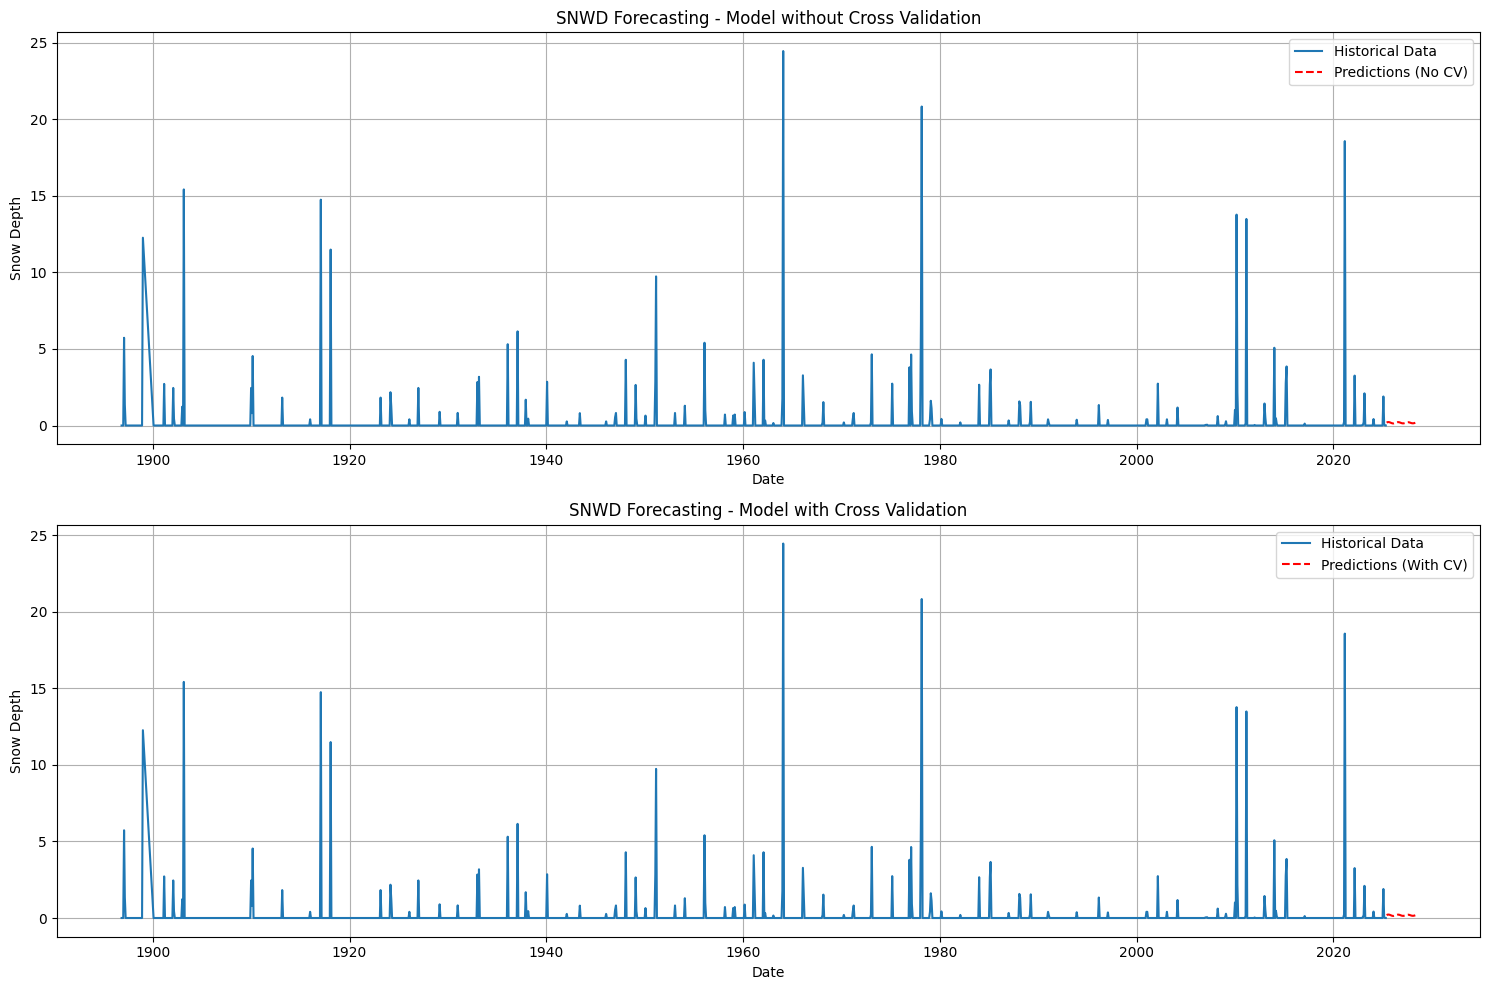

In [ ]:
# Calculate number of periods for 3 years (36 months)
forecast_periods = 36

# Get predictions from both models
future_predictions_no_cv = model_no_cv.predict(n_periods=forecast_periods)
future_predictions_cv = model_cv.predict(n_periods=forecast_periods)

# Create future dates for predictions
last_date = pd.to_datetime(data.index[-1])
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_periods, freq='M')

# Create figure with two subplots
plt.figure(figsize=(15, 10))

# Plot for model without CV
plt.subplot(2, 1, 1)
plt.plot(data.index, data['value'], label='Historical Data')
plt.plot(future_dates, future_predictions_no_cv, 'r--', label='Predictions (No CV)')
plt.title('SNWD Forecasting - Model without Cross Validation')
plt.xlabel('Date')
plt.ylabel('Snow Depth')
plt.legend()
plt.grid(True)

# Plot for model with CV
plt.subplot(2, 1, 2)
plt.plot(data.index, data['value'], label='Historical Data')
plt.plot(future_dates, future_predictions_cv, 'r--', label='Predictions (With CV)')
plt.title('SNWD Forecasting - Model with Cross Validation')
plt.xlabel('Date')
plt.ylabel('Snow Depth')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

/Users/belalelsiesy/Documents/School/4. UTD/7. Spring 2025/CS4485 - CS Project/NeuralClimate/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/belalelsiesy/Documents/School/4. UTD/7. Spring 2025/CS4485 - CS Project/NeuralClimate/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


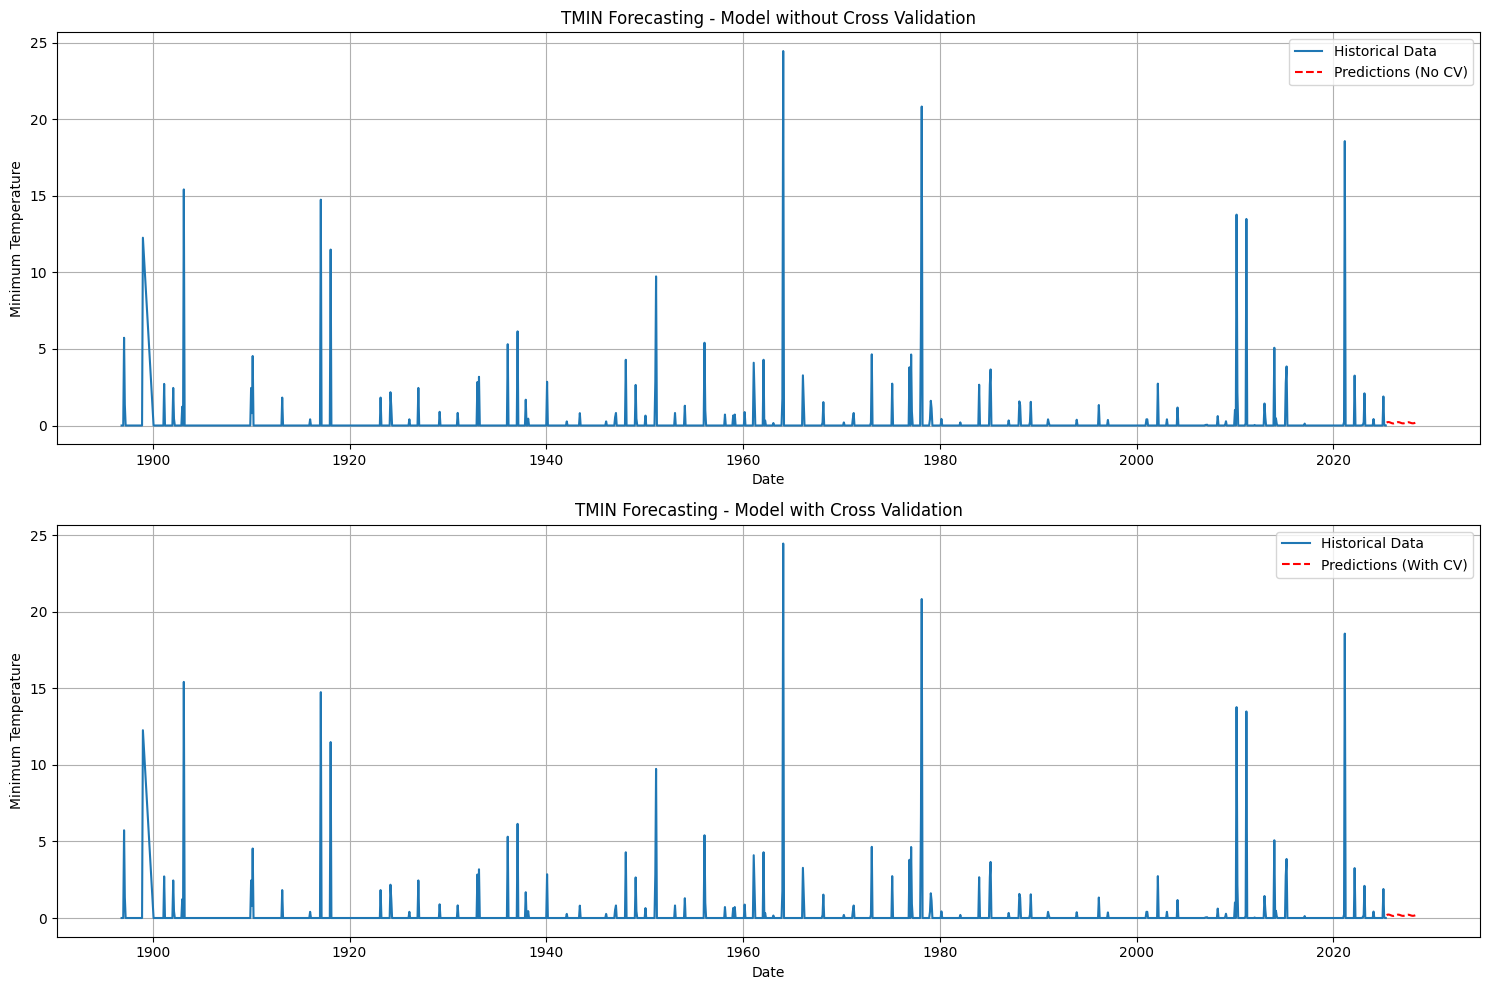

In [ ]:
# Calculate number of periods for 3 years (36 months)
forecast_periods = 36

# Get predictions from both models
future_predictions_no_cv = model_no_cv.predict(n_periods=forecast_periods)
future_predictions_cv = model_cv.predict(n_periods=forecast_periods)

# Create future dates for predictions
last_date = pd.to_datetime(data.index[-1])
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_periods, freq='M')

# Create figure with two subplots
plt.figure(figsize=(15, 10))

# Plot for model without CV
plt.subplot(2, 1, 1)
plt.plot(data.index, data['value'], label='Historical Data')
plt.plot(future_dates, future_predictions_no_cv, 'r--', label='Predictions (No CV)')
plt.title('TMIN Forecasting - Model without Cross Validation')
plt.xlabel('Date')
plt.ylabel('Minimum Temperature')
plt.legend()
plt.grid(True)

# Plot for model with CV
plt.subplot(2, 1, 2)
plt.plot(data.index, data['value'], label='Historical Data')
plt.plot(future_dates, future_predictions_cv, 'r--', label='Predictions (With CV)')
plt.title('TMIN Forecasting - Model with Cross Validation')
plt.xlabel('Date')
plt.ylabel('Minimum Temperature')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import pickle
import os
import pandas as pd

import matplotlib.pyplot as plt

# Load the TMIN model
tmin_model_path = os.path.join(project_root, 'models', 'TMIN_model_cv.pkl')
with open(tmin_model_path, 'rb') as f:
    tmin_model = pickle.load(f)

# Calculate number of periods for 2 years (24 months)
forecast_periods = 24

# Make predictions
future_predictions = tmin_model.predict(n_periods=forecast_periods)

# Convert dates to datetime and get last 5 years of data
tmin_data['DATE'] = pd.to_datetime(tmin_data['DATE'])
five_years_ago = tmin_data['DATE'].max() - pd.DateOffset(years=5)
recent_data = tmin_data[tmin_data['DATE'] >= five_years_ago]

# Create future dates for predictions
last_date = recent_data['DATE'].max()
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_periods, freq='M')

# Plot historical data and predictions
plt.figure(figsize=(15, 6))
plt.plot(recent_data['DATE'], recent_data['value'], label='Historical Data (Last 5 Years)')
plt.plot(future_dates, future_predictions, 'r--', label='Predictions (Next 2 Years)')
plt.title('TMIN Temperature Forecasting')
plt.xlabel('Date')
plt.ylabel('Minimum Temperature')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'project_root' is not defined